In [4]:
import os
import zipfile
import cv2
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision.models as models
import timm

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import copy
import time

import random
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [5]:
labels_csv_path = "/kaggle/input/unified-dataset/labels.csv"
labels_df = pd.read_csv(labels_csv_path)

In [6]:
def apply_clahe(img, **kwargs):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl,a,b))
    final = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

    return final

In [36]:
def get_transforms(train=True):
    if train:
        return A.Compose([
            A.Lambda(image=apply_clahe),
            A.Resize(512, 512),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Rotate(limit=15, p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Lambda(image=apply_clahe),
            A.Resize(512, 512),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

In [8]:
class GlaucomaDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.loc[idx, 'image_path'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df.loc[idx, 'label']

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label, img_path

In [9]:
train_df, val_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['label'], random_state=42)

In [10]:
train_dataset = GlaucomaDataset(train_df, root_dir="/kaggle/input/unified-dataset", transform=get_transforms(train=True))
val_dataset = GlaucomaDataset(val_df, root_dir="/kaggle/input/unified-dataset", transform=get_transforms(train=False))

In [11]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

In [12]:
dataloaders = {'train': train_loader, 'val': val_loader}

In [13]:
print("Preprocessing Done.")

Preprocessing Done.


---

In [14]:
def get_resnet50(pretrained=True, num_classes=2):
    model = models.resnet50(pretrained=pretrained)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

In [15]:
def get_efficientnet_b0(pretrained=True, num_classes=2):
    model = models.efficientnet_b0(pretrained=pretrained)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    return model

In [16]:
def get_densenet121(pretrained=True, num_classes=2):
    model = models.densenet121(pretrained=pretrained)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    return model

In [17]:
def get_vit_base_patch16_224(pretrained=True, num_classes=2):
    model = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
    model.head = nn.Linear(model.head.in_features, num_classes)

    return model

In [18]:
def get_swin_base_patch4_window7_224(pretrained=True, num_classes=2):
    model = timm.create_model('swin_base_patch4_window7_224', pretrained=pretrained)
    model.head = nn.Linear(model.head.in_features, num_classes)

    return model

In [19]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, device,
                num_epochs=25, early_stopping_patience=5, model_name="model"):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    epochs_no_improve = 0

    history = {key: [] for key in [
        'train_loss', 'val_loss', 'train_acc', 'val_acc', 'train_prec', 'val_prec',
        'train_rec', 'val_rec', 'train_f1', 'val_f1', 'train_auc', 'val_auc']}

    all_preds = {'train': {}, 'val': {}}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 20)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            all_labels = []
            all_logits = []

            for inputs, labels, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                all_labels.append(labels.cpu().numpy())
                all_logits.append(outputs.detach().cpu().numpy())

            # After full epoch:
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            all_labels = np.concatenate(all_labels)
            all_logits = np.concatenate(all_logits)

            probs = torch.softmax(torch.from_numpy(all_logits), dim=1).numpy()
            preds = np.argmax(probs, axis=1)

            acc = accuracy_score(all_labels, preds)
            prec = precision_score(all_labels, preds, zero_division=0)
            rec = recall_score(all_labels, preds, zero_division=0)
            f1 = f1_score(all_labels, preds, zero_division=0)
            try:
                auc = roc_auc_score(all_labels, probs[:, 1])
            except Exception:
                auc = 0.0

            # Save metrics
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(acc)
            history[f'{phase}_prec'].append(prec)
            history[f'{phase}_rec'].append(rec)
            history[f'{phase}_f1'].append(f1)
            history[f'{phase}_auc'].append(auc)

            all_preds[phase]['y_true'] = all_labels
            all_preds[phase]['y_pred'] = preds

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {acc:.4f} Prec: {prec:.4f} Rec: {rec:.4f} F1: {f1:.4f} AUC: {auc:.4f}")

            if phase == 'val':
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(epoch_loss)
                else:
                    scheduler.step()

                if f1 > best_f1:
                    best_f1 = f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(best_model_wts, f'{model_name}_best.pth')
                    print(f"--> Best model saved with val F1: {best_f1:.4f}")
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs with no improvement.")
            break

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val F1: {best_f1:.4f}")

    model.load_state_dict(best_model_wts)

    return model, history, all_preds

In [20]:
def plot_metrics_single_model(history, model_name):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(16, 10))

    # Loss
    plt.subplot(2, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(2, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Precision
    plt.subplot(2, 3, 3)
    plt.plot(epochs, history['train_prec'], label='Train Precision')
    plt.plot(epochs, history['val_prec'], label='Val Precision')
    plt.title(f'{model_name} Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(2, 3, 4)
    plt.plot(epochs, history['train_rec'], label='Train Recall')
    plt.plot(epochs, history['val_rec'], label='Val Recall')
    plt.title(f'{model_name} Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    # F1-score
    plt.subplot(2, 3, 5)
    plt.plot(epochs, history['train_f1'], label='Train F1')
    plt.plot(epochs, history['val_f1'], label='Val F1')
    plt.title(f'{model_name} F1-score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.legend()

    # AUC
    plt.subplot(2, 3, 6)
    plt.plot(epochs, history['train_auc'], label='Train AUC')
    plt.plot(epochs, history['val_auc'], label='Val AUC')
    plt.title(f'{model_name} ROC AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [21]:
def plot_metrics_for_publication(history, model_name, save_path=None):
    epochs = range(1, len(history['train_loss']) + 1)
    metrics = ['loss', 'acc', 'prec', 'rec', 'f1', 'auc']
    titles = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC']

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        axes[i].plot(epochs, history[f'train_{metric}'], label='Train', linewidth=2)
        axes[i].plot(epochs, history[f'val_{metric}'], label='Validation', linewidth=2)
        axes[i].set_title(f'{titles[i]}', fontsize=14)
        axes[i].set_xlabel('Epoch', fontsize=12)
        axes[i].set_ylabel(titles[i], fontsize=12)
        axes[i].legend()
        axes[i].grid(True)

    plt.suptitle(f'{model_name.upper()} Performance Metrics', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [22]:
def print_final_metrics_for_report(history):
    final_epoch = len(history['train_loss']) - 1
    metrics = ['loss', 'acc', 'prec', 'rec', 'f1', 'auc']
    print(f"{'Metric':<10} | {'Train':>10} | {'Validation':>10}")
    print("-" * 36)
    for metric in metrics:
        train_val = history[f'train_{metric}'][final_epoch]
        val_val = history[f'val_{metric}'][final_epoch]
        print(f"{metric.capitalize():<10} | {train_val:10.4f} | {val_val:10.4f}")

In [23]:
def save_metrics_to_csv(history, filename="final_metrics.csv"):
    final_epoch = len(history['train_loss']) - 1
    data = {
        'Metric': [],
        'Train': [],
        'Validation': []
    }
    for metric in ['loss', 'acc', 'prec', 'rec', 'f1', 'auc']:
        data['Metric'].append(metric)
        data['Train'].append(history[f'train_{metric}'][final_epoch])
        data['Validation'].append(history[f'val_{metric}'][final_epoch])
    
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Metrics saved to {filename}")

In [24]:
def plot_confusion_matrix_single_model(y_true, y_pred, model_name):
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Blues', normalize='true')
    disp.ax_.set_title(f'{model_name} Normalized Confusion Matrix')
    plt.show()

In [25]:
def generate_gradcam(model, input_tensor, target_class, device, model_name):
    model.eval()
    input_tensor = input_tensor.unsqueeze(0).to(device)

    if model_name == 'resnet50':
        final_conv = model.layer4[2].conv3
    elif model_name == 'efficientnet_b0':
        final_conv = model.features[-1][2]
    elif model_name == 'densenet121':
        final_conv = model.features.denseblock4.denselayer16.conv2
    else:
        print("Grad-CAM not defined for this model")
        return None

    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    handle_fw = final_conv.register_forward_hook(forward_hook)
    handle_bw = final_conv.register_full_backward_hook(backward_hook)

    output = model(input_tensor)
    loss = output[0, target_class]
    model.zero_grad()
    loss.backward()

    grads = gradients[0].squeeze().cpu().detach().numpy()
    acts = activations[0].squeeze().cpu().detach().numpy()

    weights = grads.mean(axis=(1, 2))
    cam = np.zeros(acts.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * acts[i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (input_tensor.size(3), input_tensor.size(2)))
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)

    handle_fw.remove()
    handle_bw.remove()

    return cam

In [26]:
def attention_rollout(model, input_tensor, device, discard_ratio=0.9):
    model.eval()
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        attentions = []

        def get_attention(module, input, output):
            attentions.append(output)

        handles = []
        if hasattr(model, 'blocks'):
            for block in model.blocks:
                handles.append(block.attn.register_forward_hook(get_attention))
        elif hasattr(model, 'layers'):
            for layer in model.layers:
                for block in layer.blocks:
                    handles.append(block.attn.register_forward_hook(get_attention))
        else:
            print("Attention rollout: Unknown model architecture.")
            return None

        _ = model(input_tensor)

        for h in handles:
            h.remove()

        if len(attentions) == 0:
            print("Attention rollout: No attentions captured.")
            return None

        att_mat = [att[0].mean(0).cpu().numpy() for att in attentions]

        att_mat = [att + np.eye(att.shape[0]) for att in att_mat]

        att_mat = [att / att.sum(axis=1, keepdims=True) for att in att_mat]

        rollout = att_mat[0]
        for i in range(1, len(att_mat)):
            rollout = rollout @ att_mat[i]

        mask = rollout[0, 1:]

        size = int(np.sqrt(mask.shape[0]))
        mask = mask.reshape(size, size)

        mask = cv2.resize(mask, (input_tensor.size(3), input_tensor.size(2)))
        mask = mask - mask.min()
        mask = mask / (mask.max() + 1e-8)

        threshold = np.quantile(mask, discard_ratio)
        mask[mask < threshold] = 0

        return mask

In [27]:
def show_gradcam_on_image(img_tensor, cam, title="Grad-CAM"):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + img
    overlay = overlay / np.max(overlay)
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(title)
    plt.show()

In [28]:
def explain_random_image(model, dataset, device, model_name):
    model.eval()
    idx = random.randint(0, len(dataset) - 1)
    img_tensor, label, img_path = dataset[idx]
    input_tensor = img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        pred = output.argmax(dim=1).item()
    print(f"Random Image: {img_path}\nGround Truth: {label}\nPredicted: {pred}")

    if model_name in ['resnet50', 'efficientnet_b0', 'densenet121']:
        cam = generate_gradcam(model, img_tensor, pred, device, model_name)
        if cam is not None:
            show_gradcam_on_image(img_tensor, cam, title=f"Grad-CAM for {model_name}")
    elif model_name in ['vit_base_patch16_224', 'swin_base_patch4_window7_224']:
        mask = attention_rollout(model, input_tensor, device)
        if mask is not None:
            img = img_tensor.permute(1, 2, 0).cpu().numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std  = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)

            heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
            heatmap = np.float32(heatmap) / 255
            overlay = heatmap + img
            overlay = overlay / np.max(overlay)

            plt.figure(figsize=(6, 6))
            plt.imshow(overlay)
            plt.axis('off')
            plt.title(f"Attention Rollout for {model_name}")
            plt.show()
        else:
            print(f"Attention rollout explanation not available for {model_name}.")
    else:
        print(f"Explanation not implemented for {model_name}.")

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [30]:
def run_model(model_name):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model_getters = {
        'resnet50': get_resnet50,
        'efficientnet_b0': get_efficientnet_b0,
        'densenet121': get_densenet121,
        'vit_base_patch16_224': get_vit_base_patch16_224,
        'swin_base_patch4_window7_224': get_swin_base_patch4_window7_224
    }

    if model_name not in model_getters:
        raise ValueError(f"Unknown model_name {model_name}")

    model = model_getters[model_name](pretrained=True, num_classes=2).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

    criterion = nn.CrossEntropyLoss()

    model, history, all_preds = train_model(
        model, dataloaders, criterion, optimizer, scheduler,
        device=device, num_epochs=25, early_stopping_patience=5,
        model_name=model_name
    )

    plot_metrics_for_publication(history, model_name=model_name, save_path=f"{model_name}_metrics.pdf")

    print("\n===== Final Metrics for Publication =====")
    print_final_metrics_for_report(history)

    save_metrics_to_csv(history, filename=f"{model_name}_final_metrics.csv")

    plot_confusion_matrix_single_model(all_preds['val']['y_true'], all_preds['val']['y_pred'], model_name)

    # explain_random_image(model, val_dataset, device, model_name)

    return model, history, all_preds

Using device: cuda
Epoch 1/25
--------------------
train Loss: 0.3951 Acc: 0.8289 Prec: 0.8303 Rec: 0.8000 F1: 0.8149 AUC: 0.9040
val Loss: 0.2452 Acc: 0.9072 Prec: 0.8649 Rec: 0.9514 F1: 0.9061 AUC: 0.9673
--> Best model saved with val F1: 0.9061
Epoch 2/25
--------------------
train Loss: 0.2861 Acc: 0.8886 Prec: 0.8784 Rec: 0.8860 F1: 0.8822 AUC: 0.9501
val Loss: 0.2475 Acc: 0.9046 Prec: 0.8547 Rec: 0.9606 F1: 0.9045 AUC: 0.9718
Epoch 3/25
--------------------
train Loss: 0.2464 Acc: 0.9038 Prec: 0.8996 Rec: 0.8956 F1: 0.8976 AUC: 0.9623
val Loss: 0.2264 Acc: 0.9041 Prec: 0.9205 Rec: 0.8716 F1: 0.8954 AUC: 0.9707
Epoch 4/25
--------------------
train Loss: 0.2255 Acc: 0.9160 Prec: 0.9140 Rec: 0.9069 F1: 0.9104 AUC: 0.9676
val Loss: 0.2008 Acc: 0.9249 Prec: 0.9313 Rec: 0.9073 F1: 0.9191 AUC: 0.9757
--> Best model saved with val F1: 0.9191
Epoch 5/25
--------------------
train Loss: 0.2092 Acc: 0.9226 Prec: 0.9175 Rec: 0.9181 F1: 0.9178 AUC: 0.9721
val Loss: 0.1892 Acc: 0.9283 Prec: 0

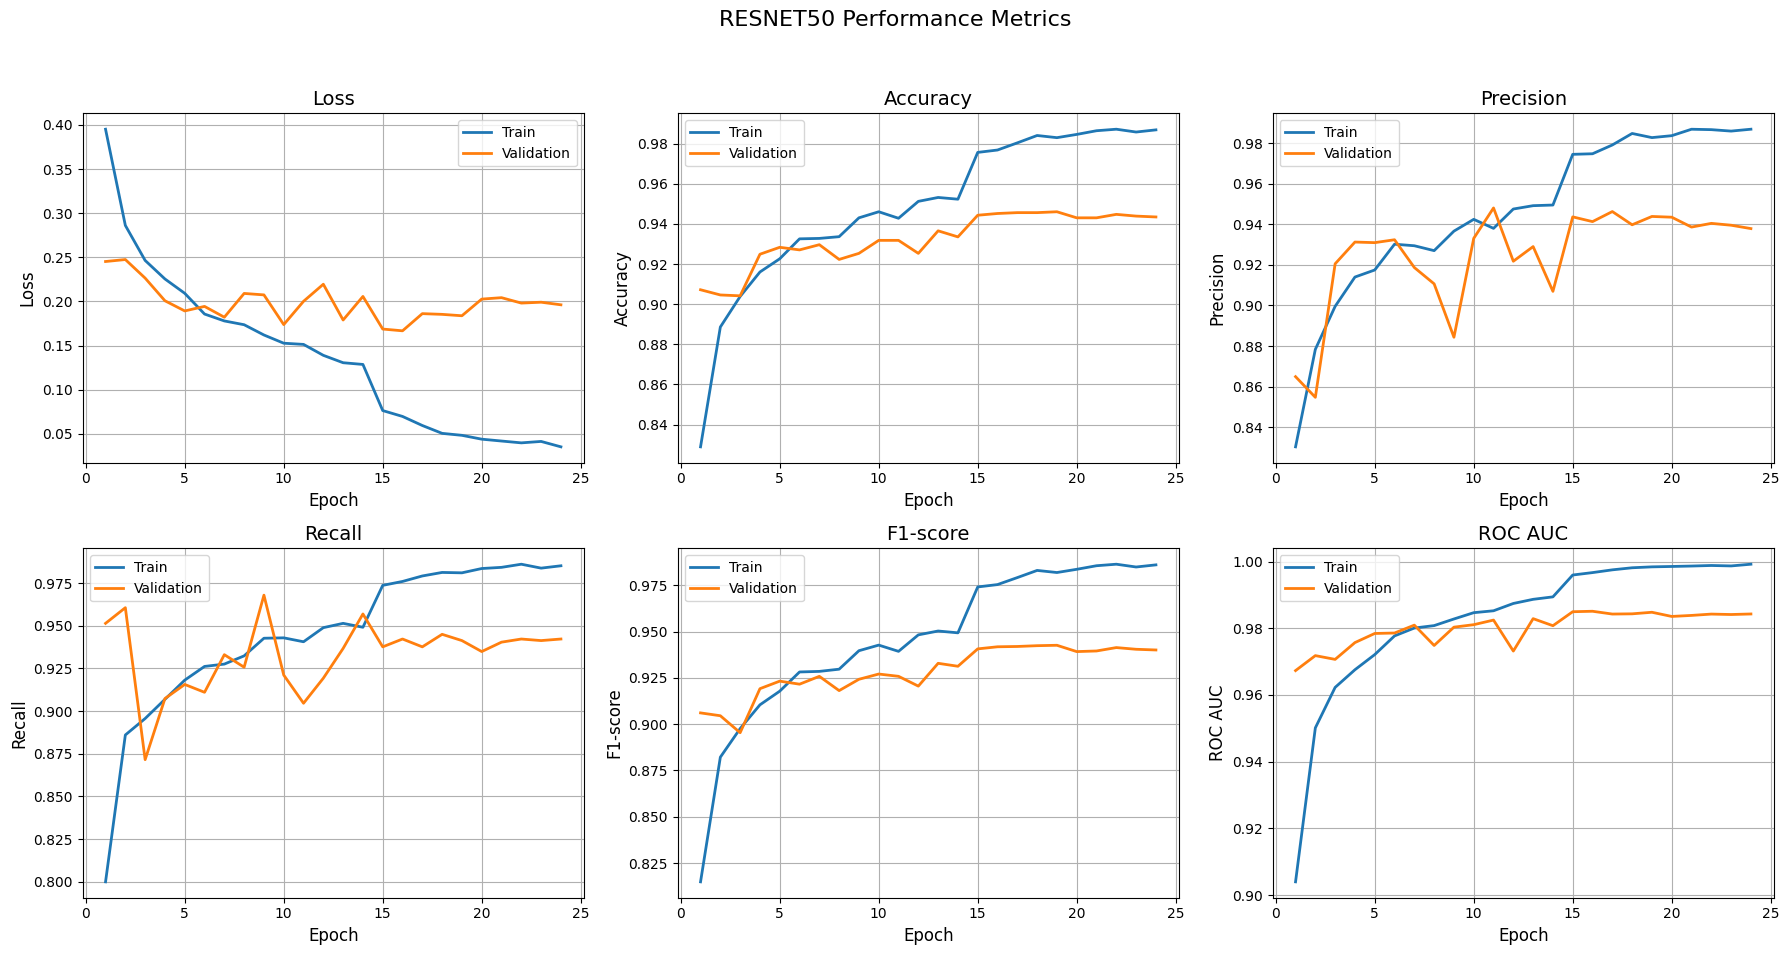


===== Final Metrics for Publication =====
Metric     |      Train | Validation
------------------------------------
Loss       |     0.0353 |     0.1962
Acc        |     0.9868 |     0.9434
Prec       |     0.9869 |     0.9379
Rec        |     0.9851 |     0.9422
F1         |     0.9860 |     0.9400
Auc        |     0.9992 |     0.9843
Metrics saved to resnet50_final_metrics.csv


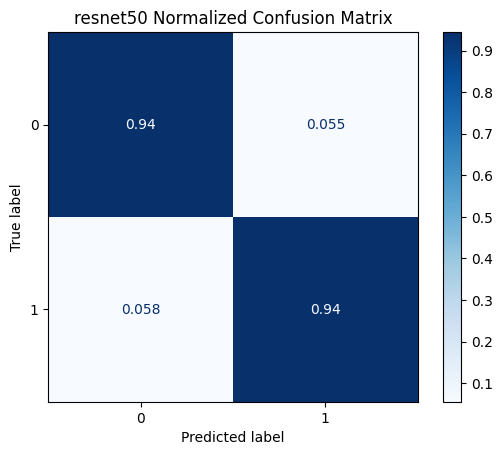

In [36]:
model_resnet, history_resnet, preds_resnet = run_model('resnet50')

Random Image: /kaggle/input/unified-dataset/images/EYEPACS_EyePACS-TRAIN-RG-867.jpg
Ground Truth: 1
Predicted: 1


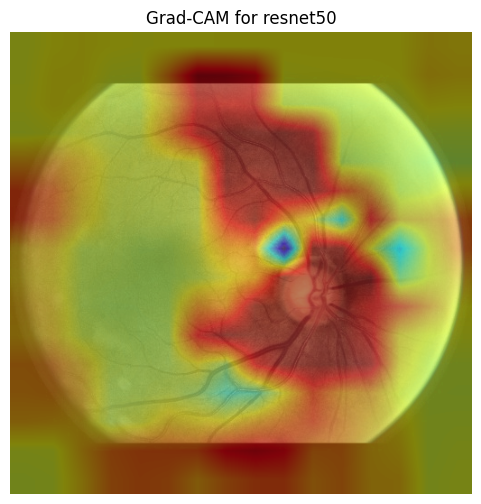

In [38]:
explain_random_image(model_resnet, val_dataset, device, 'resnet50')

Using device: cuda
Epoch 1/25
--------------------


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train Loss: 0.3851 Acc: 0.8260 Prec: 0.8175 Rec: 0.8115 F1: 0.8145 AUC: 0.9078
val Loss: 0.2313 Acc: 0.9067 Prec: 0.9284 Rec: 0.8688 F1: 0.8976 AUC: 0.9706
--> Best model saved with val F1: 0.8976
Epoch 2/25
--------------------
train Loss: 0.2513 Acc: 0.9004 Prec: 0.8921 Rec: 0.8968 F1: 0.8944 AUC: 0.9610
val Loss: 0.2018 Acc: 0.9193 Prec: 0.9371 Rec: 0.8881 F1: 0.9119 AUC: 0.9779
--> Best model saved with val F1: 0.9119
Epoch 3/25
--------------------
train Loss: 0.1983 Acc: 0.9283 Prec: 0.9202 Rec: 0.9282 F1: 0.9242 AUC: 0.9751
val Loss: 0.1817 Acc: 0.9270 Prec: 0.9093 Rec: 0.9385 F1: 0.9237 AUC: 0.9806
--> Best model saved with val F1: 0.9237
Epoch 4/25
--------------------
train Loss: 0.1723 Acc: 0.9345 Prec: 0.9258 Rec: 0.9358 F1: 0.9308 AUC: 0.9811
val Loss: 0.1952 Acc: 0.9262 Prec: 0.9372 Rec: 0.9037 F1: 0.9201 AUC: 0.9796
Epoch 5/25
--------------------
train Loss: 0.1442 Acc: 0.9449 Prec: 0.9393 Rec: 0.9440 F1: 0.9417 AUC: 0.9868
val Loss: 0.1768 Acc: 0.9365 Prec: 0.9082 Rec:

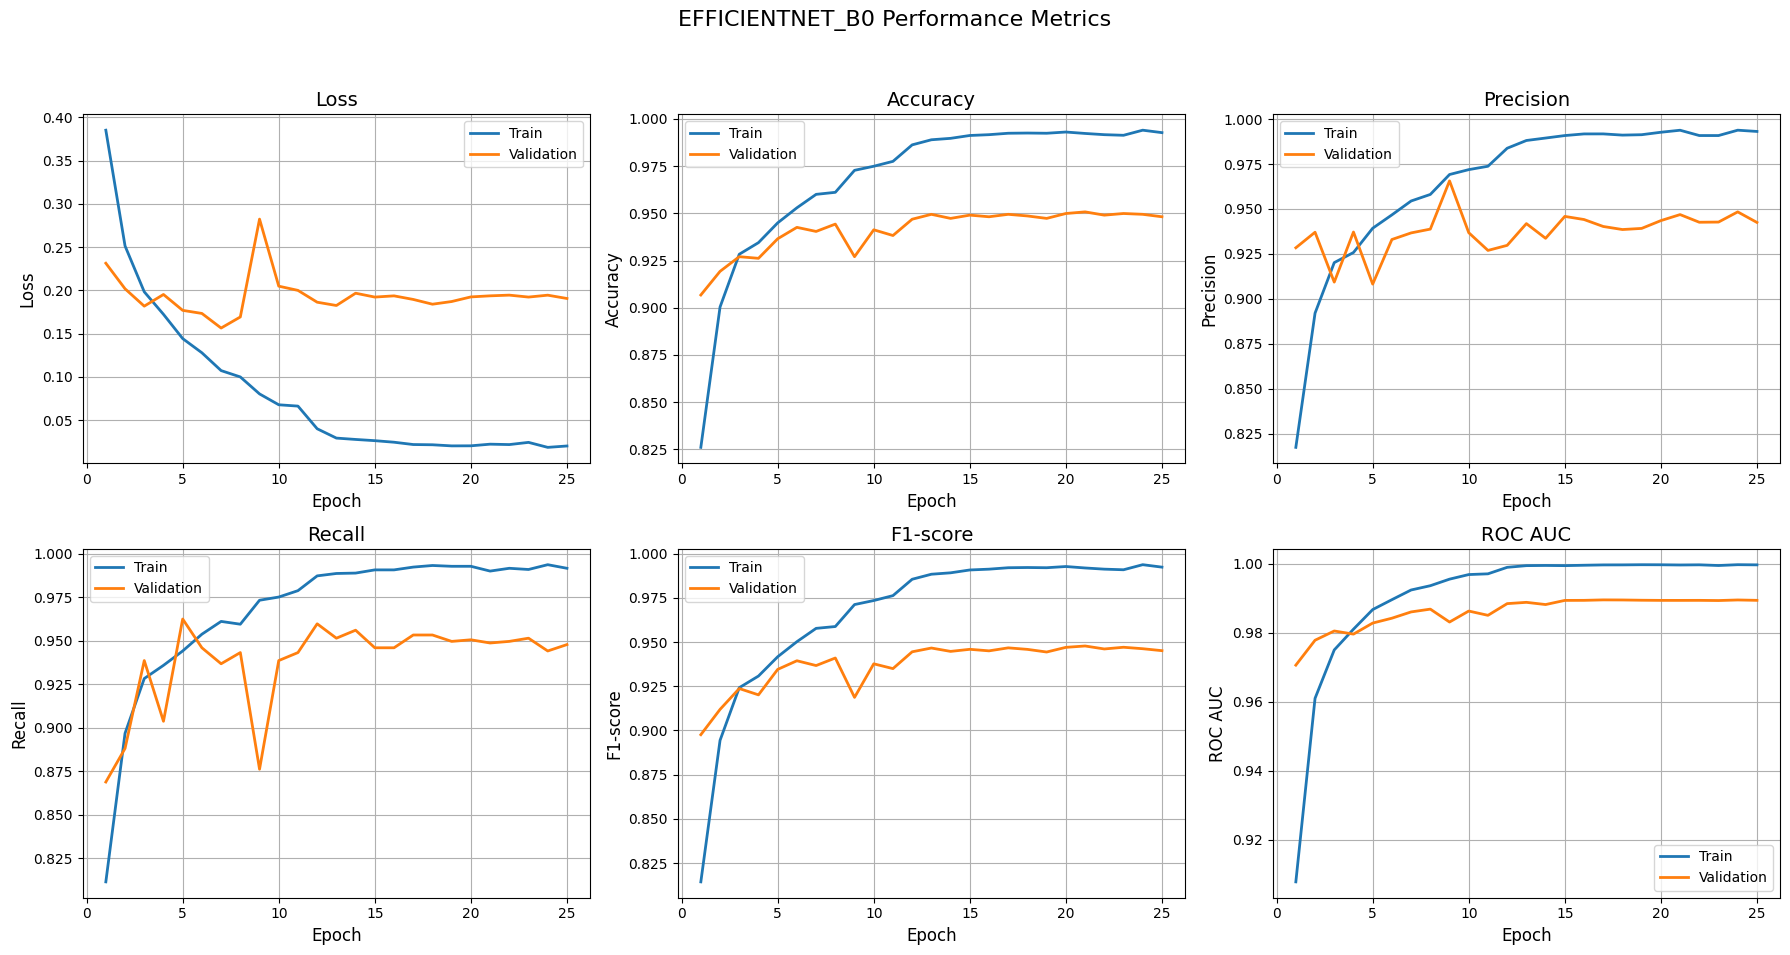


===== Final Metrics for Publication =====
Metric     |      Train | Validation
------------------------------------
Loss       |     0.0201 |     0.1906
Acc        |     0.9928 |     0.9482
Prec       |     0.9931 |     0.9425
Rec        |     0.9915 |     0.9477
F1         |     0.9923 |     0.9451
Auc        |     0.9997 |     0.9894
Metrics saved to efficientnet_b0_final_metrics.csv


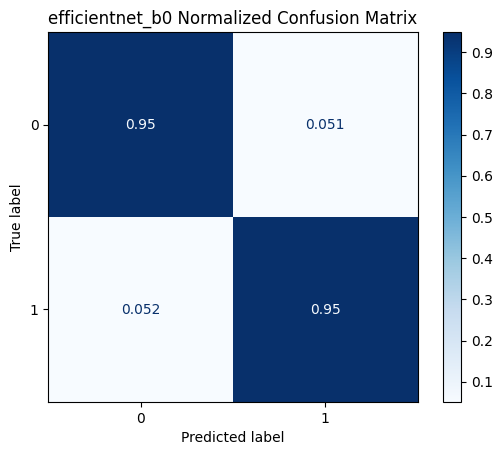

In [69]:
model_efficientnet, history_efficientnet, preds_efficientnet = run_model('efficientnet_b0')

Random Image: /kaggle/input/unified-dataset/images/EYEPACS_EyePACS-TRAIN-NRG-2348.jpg
Ground Truth: 0
Predicted: 0


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


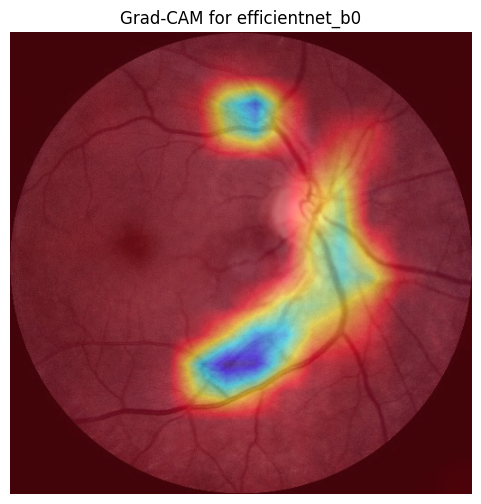

In [70]:
explain_random_image(model_efficientnet, val_dataset, device, 'efficientnet_b0')

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 170MB/s]


Epoch 1/25
--------------------
train Loss: 0.3848 Acc: 0.8314 Prec: 0.8169 Rec: 0.8271 F1: 0.8220 AUC: 0.9090
val Loss: 0.2424 Acc: 0.9054 Prec: 0.8657 Rec: 0.9459 F1: 0.9040 AUC: 0.9683
--> Best model saved with val F1: 0.9040
Epoch 2/25
--------------------
train Loss: 0.2695 Acc: 0.8977 Prec: 0.8865 Rec: 0.8975 F1: 0.8920 AUC: 0.9545
val Loss: 0.2071 Acc: 0.9223 Prec: 0.9136 Rec: 0.9220 F1: 0.9178 AUC: 0.9740
--> Best model saved with val F1: 0.9178
Epoch 3/25
--------------------
train Loss: 0.2329 Acc: 0.9121 Prec: 0.9042 Rec: 0.9096 F1: 0.9069 AUC: 0.9656
val Loss: 0.2018 Acc: 0.9266 Prec: 0.8993 Rec: 0.9505 F1: 0.9242 AUC: 0.9774
--> Best model saved with val F1: 0.9242
Epoch 4/25
--------------------
train Loss: 0.2026 Acc: 0.9222 Prec: 0.9180 Rec: 0.9165 F1: 0.9173 AUC: 0.9739
val Loss: 0.2001 Acc: 0.9154 Prec: 0.8676 Rec: 0.9679 F1: 0.9150 AUC: 0.9823
Epoch 5/25
--------------------
train Loss: 0.1771 Acc: 0.9377 Prec: 0.9318 Rec: 0.9362 F1: 0.9340 AUC: 0.9794
val Loss: 0.18

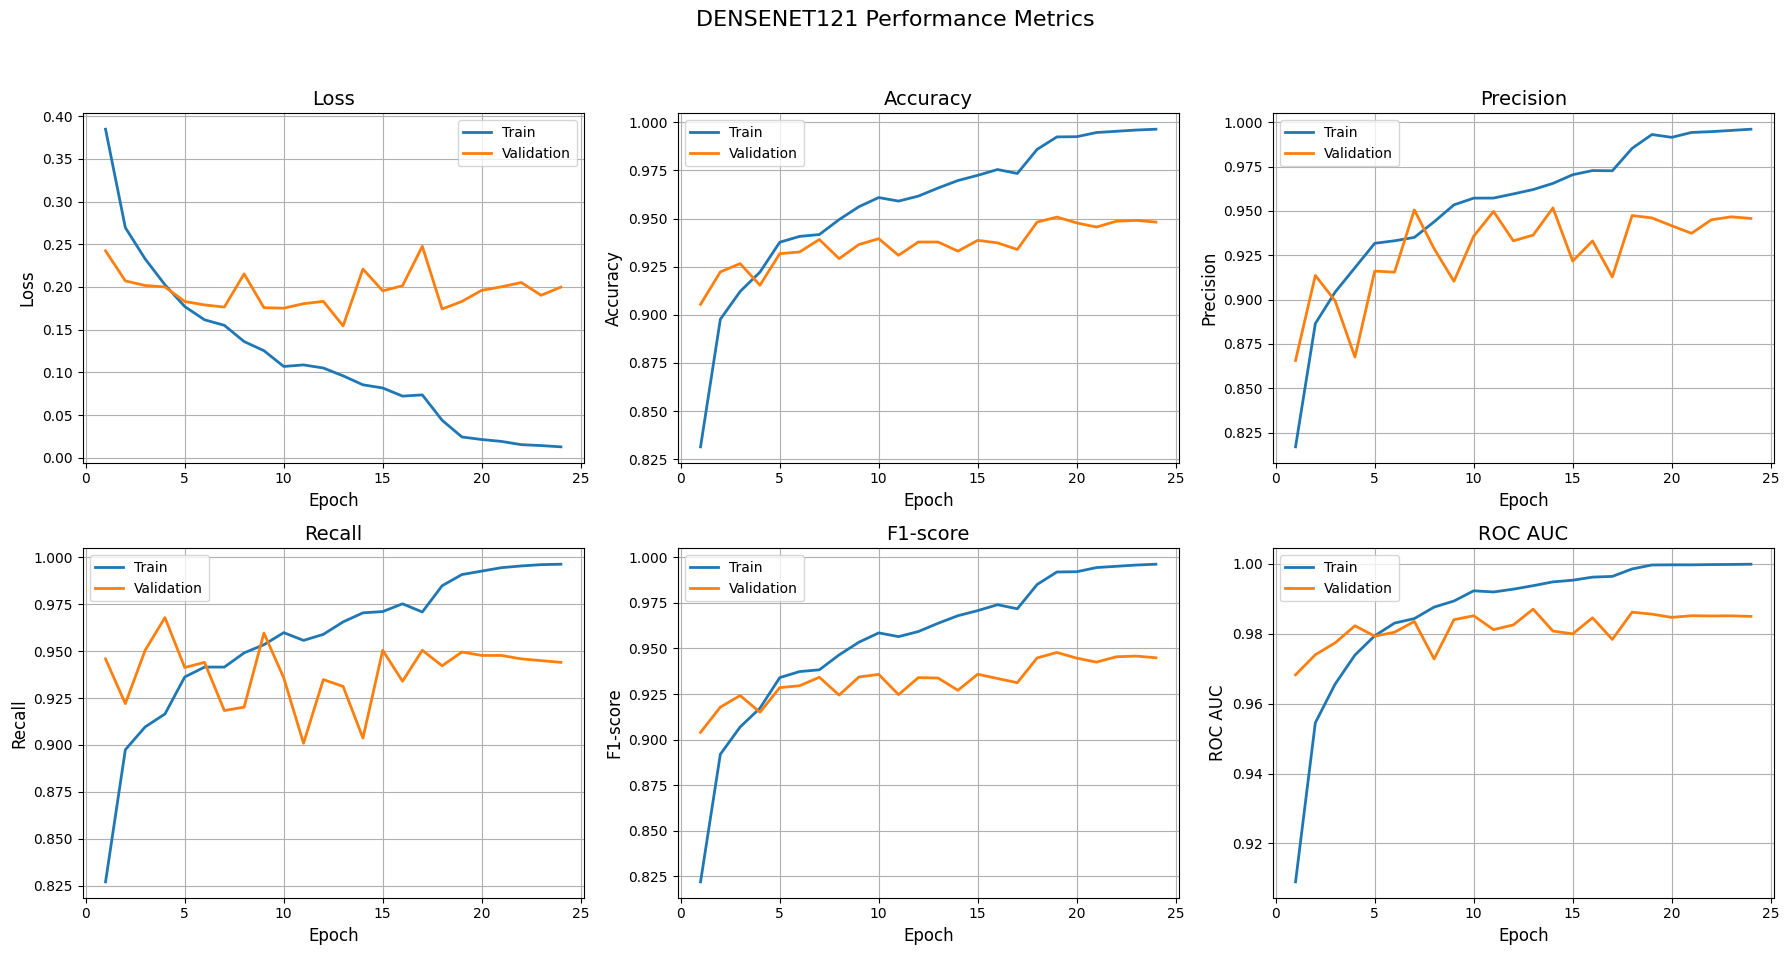


===== Final Metrics for Publication =====
Metric     |      Train | Validation
------------------------------------
Loss       |     0.0128 |     0.1998
Acc        |     0.9964 |     0.9482
Prec       |     0.9961 |     0.9458
Rec        |     0.9963 |     0.9440
F1         |     0.9962 |     0.9449
Auc        |     0.9999 |     0.9850
Metrics saved to densenet121_final_metrics.csv


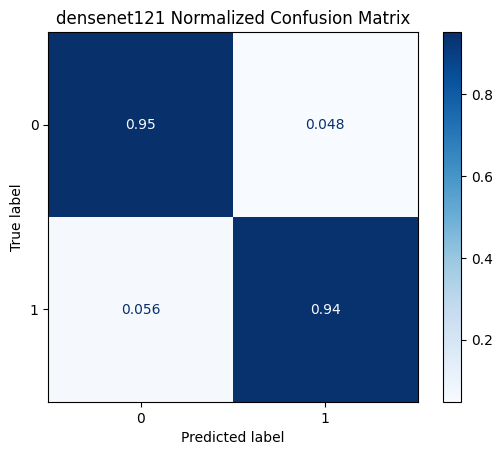

In [71]:
model_densenet, history_densenet, preds_densenet = run_model('densenet121')